# WISDM HAR

Class
- Walking, Jogging, Upstairs, Downstairs, Sitting, Standing

Sampling rate
- 20Hz

Fields
- user, activity, timestamp, x-acceleration, y-acceleration, z-acceleration



In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv1D, MaxPool1D, BatchNormalization, Dense,
                                     Input, ReLU, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, GRU)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [33]:
LABELS = ["Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing"]

In [34]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/AI_data/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";") # comment: ';'로 시작하는 줄 무시(주석)


In [35]:
data.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,NaN
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,NaN
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,NaN
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,NaN
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,NaN
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,NaN


In [36]:
def convert_to_float(x):
    try:
        return np.float32(x)
    except:
        return np.nan

In [37]:
df = data.drop('NaN', axis=1)
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,1


In [38]:
df = df.dropna()
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,0


In [39]:
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')

df["x_axis"] = df["x_axis"].apply(convert_to_float)
df["y_axis"] = df["y_axis"].apply(convert_to_float)
df["z_axis"] = df["z_axis"].apply(convert_to_float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float32
 4   y_axis     1098203 non-null  float32
 5   z_axis     1098203 non-null  float32
dtypes: float32(3), int64(2), object(1)
memory usage: 46.1+ MB


In [40]:
df['activity'].value_counts()

,count
activity,
Walking,424397
Jogging,342176
Upstairs,122869
Downstairs,100427
Sitting,59939
Standing,48395


In [41]:
df['user_id'].value_counts()

,count
user_id,
20,56632
19,45383
31,44282
8,41188
29,38245
14,38192
13,37093
34,35947
32,35506


In [42]:
# Label Encoding
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])
num_classes = len(label_encoder.classes_)

df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,activity_encoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [43]:
# label_encoder 매핑 결과 보기
dict(enumerate(label_encoder.classes_))

{0: 'Downstairs',
 1: 'Jogging',
 2: 'Sitting',
 3: 'Standing',
 4: 'Upstairs',
 5: 'Walking'}

In [44]:
# Data Split
df_train = df[df['user_id'] <= 28]
df_val   = df[(df['user_id'] > 28) & (df['user_id'] <= 32)]
df_test = df[df['user_id'] > 32]

In [45]:
# 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.fit_transform(df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']])
# test 셋에서 train에서 학습한 scaler 사용
df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']])
df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']])

Segmentation
- 슬라이딩 윈도우 방식
- 데이터를 time_steps만큼 자르고 step 간격으로 이동
- 해당 구간에서 가장 많이 나타난 label을 출력값으로 저장
- 결과적으로 딥러닝 모델에 넣을 수 있는 3차원 입력 데이터와 라벨 벡터를 생성
- 3차원 입력 데이터: (샘플 수, 한 샘플이 가지는 시간 길이, feature 개수)

In [46]:
def create_dataset(x, y, time_steps=200, step=40):
    xs, ys = [], []
    for i in range(0, len(x) - time_steps, step):
        v = x.iloc[i:i + time_steps].values
        labels = y.iloc[i:i + time_steps]
        values, counts = np.unique(labels, return_counts=True)
        mode_label = values[np.argmax(counts)]
        xs.append(v)
        ys.append(mode_label)
    return np.array(xs), np.array(ys)

TIME_STEPS = 200
STEP = 40
x_train, y_train = create_dataset(df_train[['x_axis', 'y_axis', 'z_axis']], df_train['activity_encoded'], TIME_STEPS, STEP)
x_val, y_val = create_dataset(df_val[['x_axis', 'y_axis', 'z_axis']], df_val['activity_encoded'], TIME_STEPS, STEP)
x_test, y_test = create_dataset(df_test[['x_axis', 'y_axis', 'z_axis']], df_test['activity_encoded'], TIME_STEPS, STEP)

In [47]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((20865, 200, 3), (20865,), (3580, 200, 3), (3580,), (2997, 200, 3), (2997,))

In [48]:
def positional_encoding(length, depth):
    depth = depth/2
    positions = np.arange(length)[:, np.newaxis] # 각 시퀀스 위치 pos 벡터
    depths = np.arange(depth)[np.newaxis, :]/depth # /depth로 정규화,
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates # broadcasting
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

In [49]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = int(embed_dim)
        self.num_heads = int(num_heads)
        self.ff_dim = int(ff_dim)
        self.rate = float(rate)

        self.att = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads
        )
        self.ffn = Sequential([
            Dense(self.ff_dim, activation="relu"),
            Dense(self.embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(self.rate)
        self.dropout2 = Dropout(self.rate)

    def call(self, inputs, training=None):
        attn = self.att(inputs, inputs, training=training)
        x1 = self.layernorm1(inputs + self.dropout1(attn, training=training))
        ffn = self.ffn(x1, training=training)
        return self.layernorm2(x1 + self.dropout2(ffn, training=training))

## Model 1
- CNN 2, GRU 2, Transformer 1

In [50]:
input_shape = (x_train.shape[1], x_train.shape[2])  # (time_steps, features)
num_classes = 6

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    # CNN 특징 추출 레이어
    x = Conv1D(128, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GRU(256, return_sequences=True)(x)
    x = GRU(256, return_sequences=True)(x)

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 200, 128)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 100, 256)       │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,255,430 (4.79 MB)

 Trainable params: 1,254,662 (4.79 MB)

 Non-trainable params: 768 (3.00 KB)

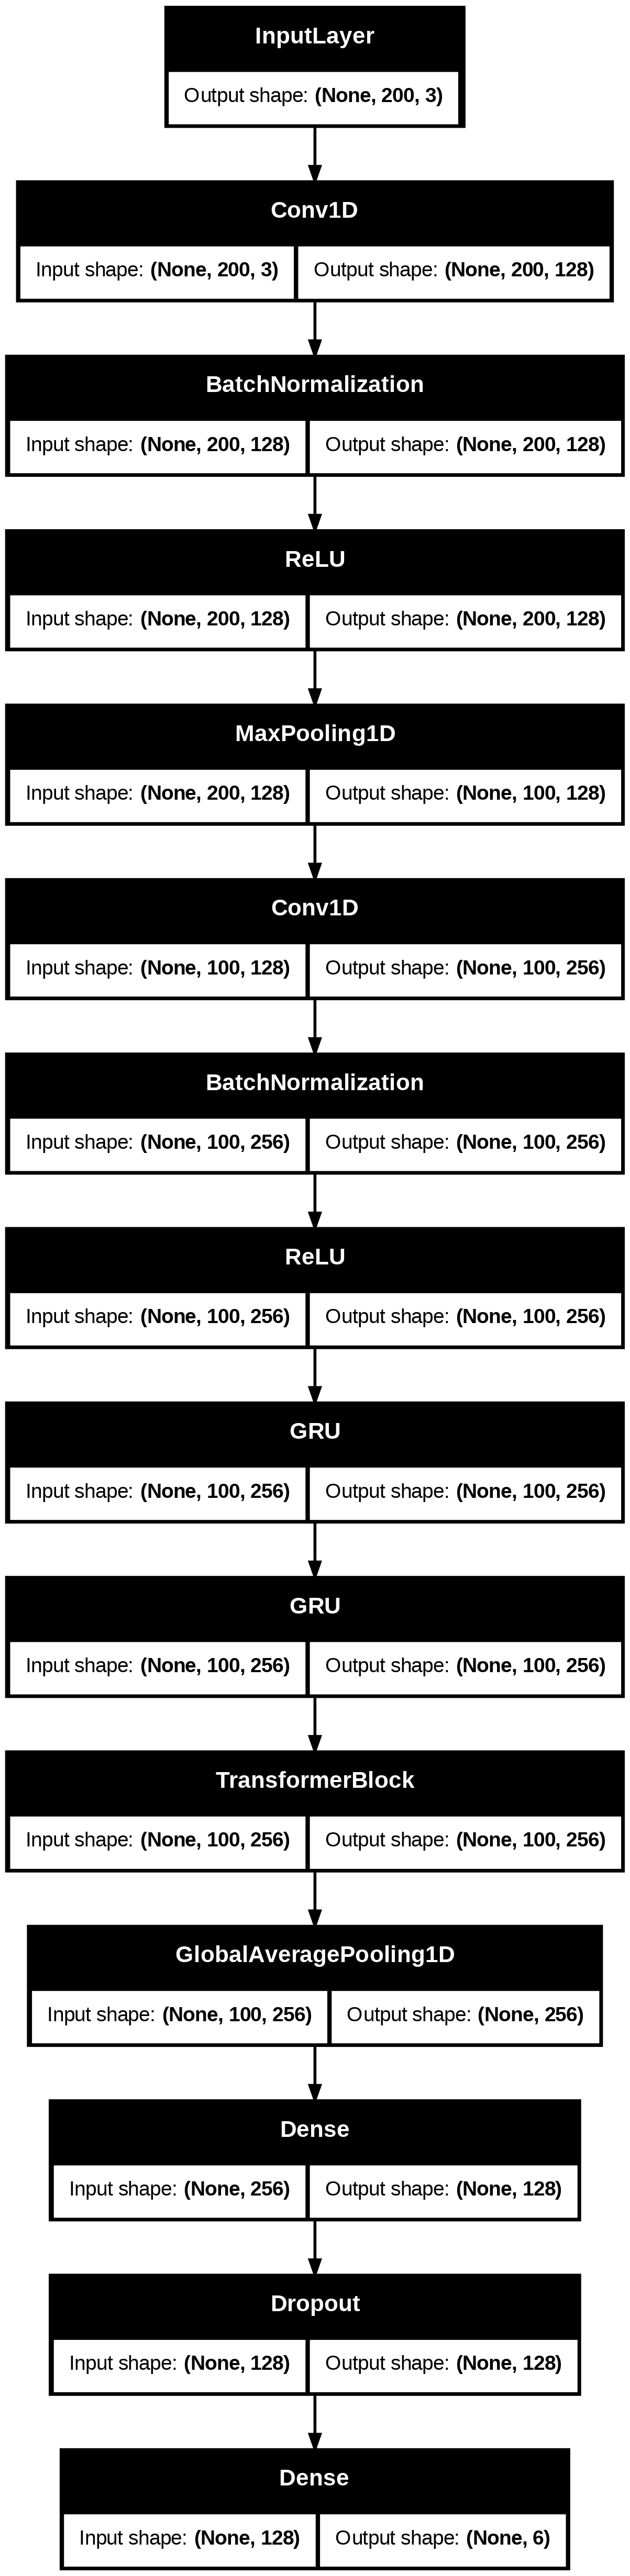

In [51]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [52]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_CNN_Transformer_best2.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [53]:
history = model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5429 - sparse_categorical_accuracy: 0.8069
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.82318, saving model to WIDSM_HAR_CNN_Transformer_best2.weights.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.5416 - sparse_categorical_accuracy: 0.8074 - val_loss: 0.6340 - val_sparse_categorical_accuracy: 0.8232
Epoch 2/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1997 - sparse_categorical_accuracy: 0.9365
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.82318
327/327 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.1995 - sparse_categorical_accuracy: 0.9365 - val_loss: 1.3403 - val_sparse_categorical_accuracy: 0.7992
Epoch 3/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1801 - sparse_categorical_accuracy: 0.9451
Epoch 3: val_sparse_categorical_accuracy improved from 0.82318 to 0.84078, saving model to WIDSM_HAR_CNN_Transformer_best2.weights.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 2

In [54]:
# 모델 평가
model = build_model(input_shape, num_classes)
model.load_weights("WIDSM_HAR_CNN_Transformer_best2.weights.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 96.86%
Training loss: 0.0957
Test accuracy: 94.59%
Test loss: 0.2669


In [55]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7977    0.9477    0.8662       287
           1     0.9979    0.9435    0.9699      1009
           2     0.9955    0.9910    0.9933       223
           3     0.9187    0.9932    0.9545       148
           4     0.9865    0.7578    0.8571       289
           5     0.9326    0.9837    0.9575      1041

    accuracy                         0.9459      2997
   macro avg     0.9381    0.9362    0.9331      2997
weighted avg     0.9509    0.9459    0.9458      2997



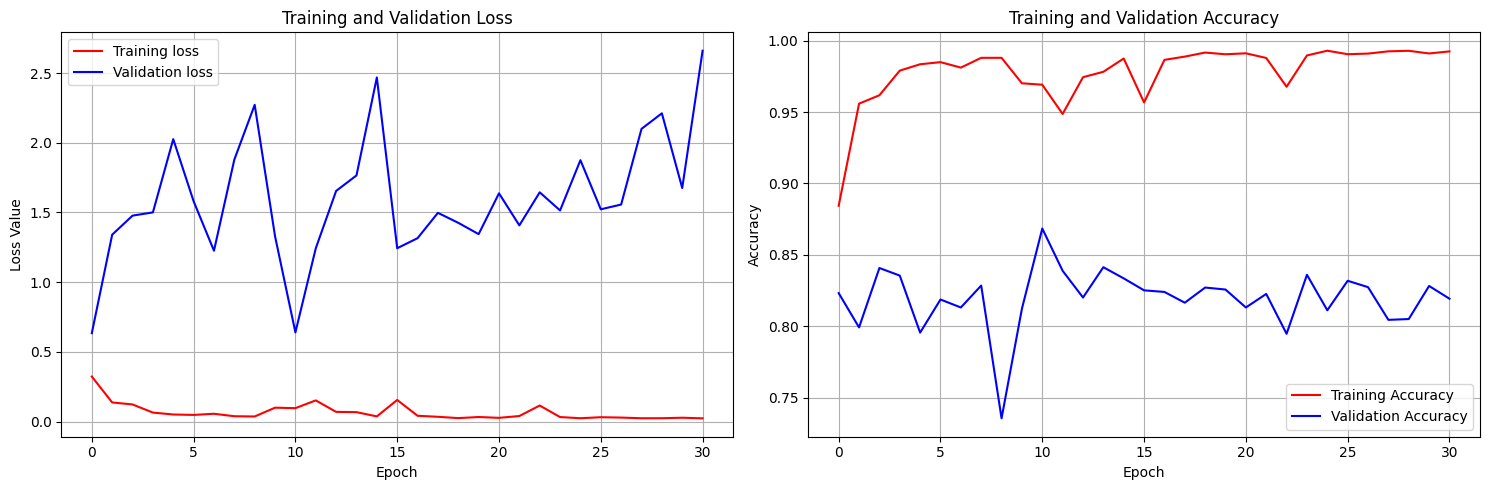

In [56]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

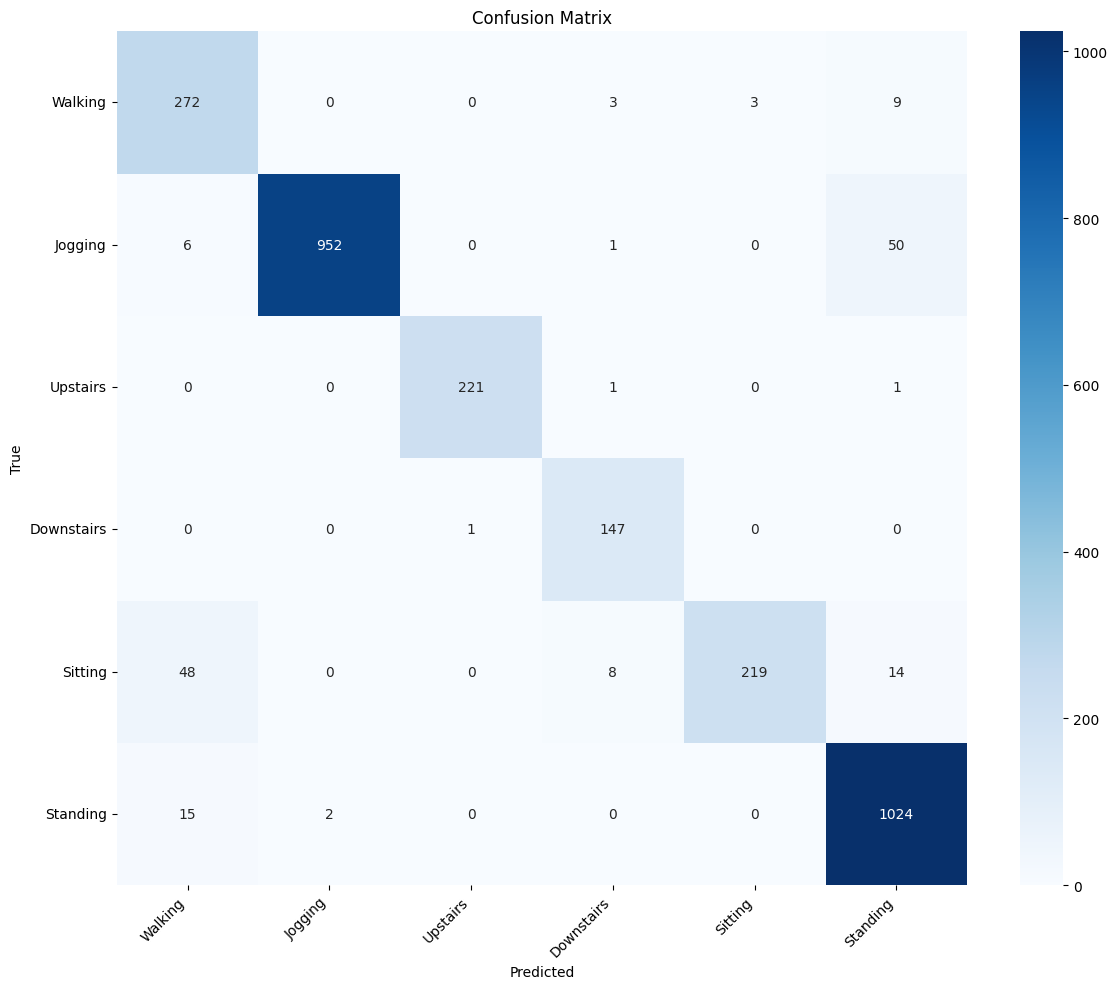

In [57]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- CNN 3, GRU 2, Transformer 1

In [58]:
input_shape = (x_train.shape[1], x_train.shape[2])  # (time_steps, features)
num_classes = 6

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    # CNN 특징 추출 레이어
    x = Conv1D(64, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GRU(256, return_sequences=True)(x)
    x = GRU(256, return_sequences=True)(x)

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 100, 256)       │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,279,366 (4.88 MB)

 Trainable params: 1,278,470 (4.88 MB)

 Non-trainable params: 896 (3.50 KB)

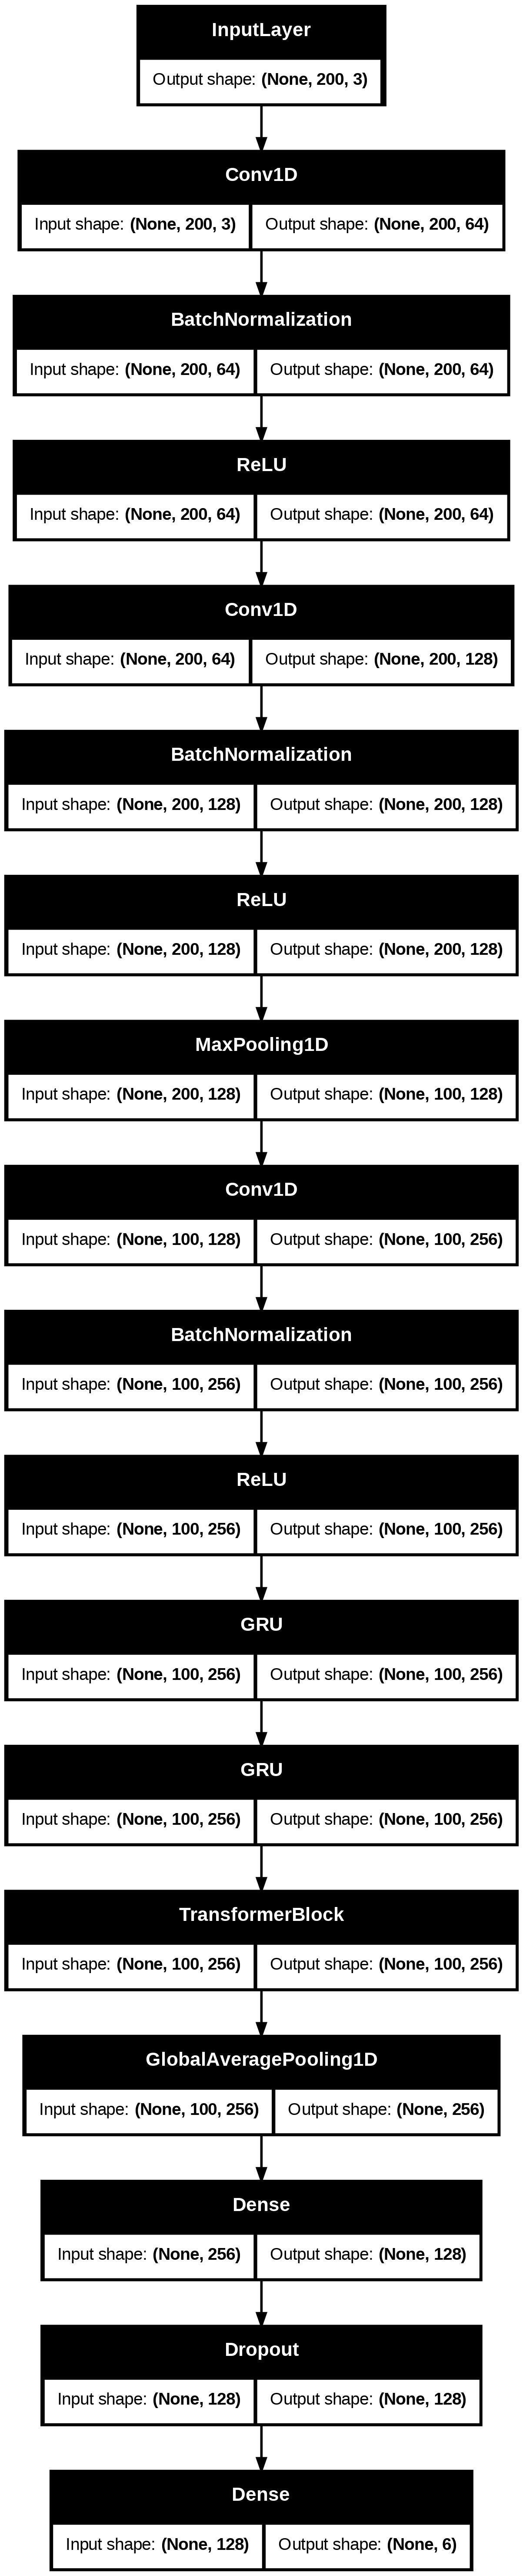

In [59]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [60]:
callbacks = [
            ModelCheckpoint(
                "WISDM_HAR_CNN_Transformer_best3.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [61]:
history = model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5428 - sparse_categorical_accuracy: 0.8091
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.74413, saving model to WISDM_HAR_CNN_Transformer_best3.weights.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.5421 - sparse_categorical_accuracy: 0.8093 - val_loss: 1.0506 - val_sparse_categorical_accuracy: 0.7441
Epoch 2/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1858 - sparse_categorical_accuracy: 0.9366
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.74413
327/327 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 0.1856 - sparse_categorical_accuracy: 0.9367 - val_loss: 2.9245 - val_sparse_categorical_accuracy: 0.6184
Epoch 3/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.9099
Epoch 3: val_sparse_categorical_accuracy improved from 0.74413 to 0.82849, saving model to WISDM_HAR_CNN_Transformer_best3.weights.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 2

In [62]:
# 모델 평가
model = build_model(input_shape, num_classes)
model.load_weights("WISDM_HAR_CNN_Transformer_best3.weights.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 97.81%
Training loss: 0.0632
Test accuracy: 90.76%
Test loss: 0.3686


In [63]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7709    0.9965    0.8693       287
           1     0.9989    0.9257    0.9609      1009
           2     0.9008    0.9776    0.9376       223
           3     0.7143    0.8108    0.7595       148
           4     0.7331    0.6367    0.6815       289
           5     0.9495    0.9395    0.9445      1041

    accuracy                         0.9076      2997
   macro avg     0.8446    0.8811    0.8589      2997
weighted avg     0.9129    0.9076    0.9078      2997



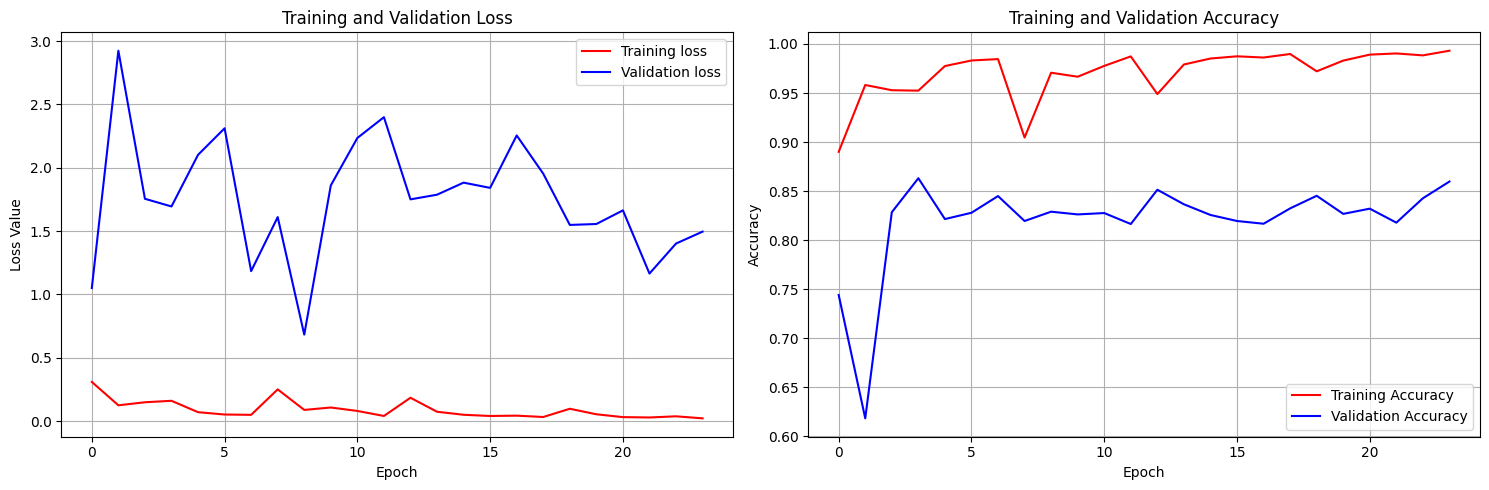

In [64]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

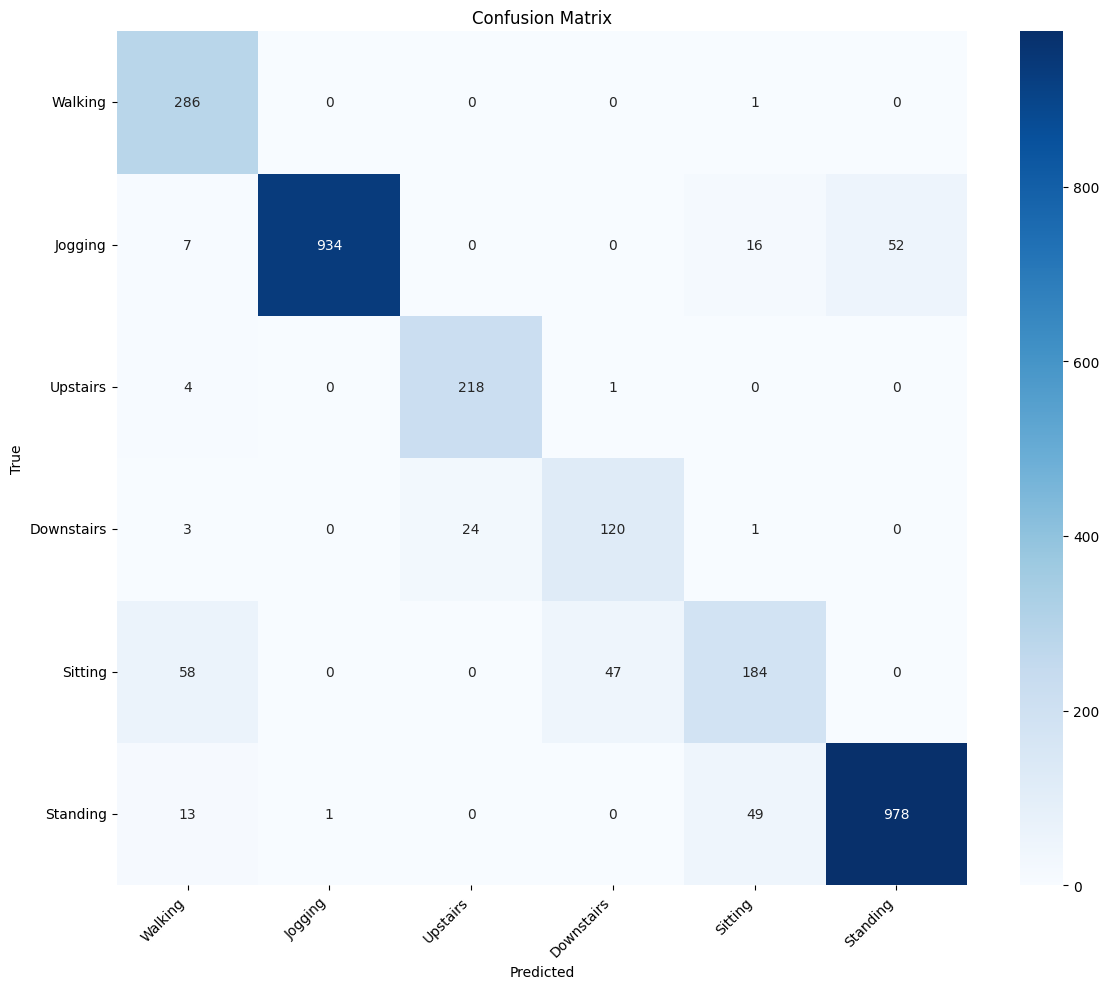

In [65]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 3
- CNN 3, GRU 2, Transformer 2

In [66]:
input_shape = (x_train.shape[1], x_train.shape[2])  # (time_steps, features)
num_classes = 6

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    x = Conv1D(64, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GRU(256, return_sequences=True)(x)
    x = GRU(256, return_sequences=True)(x)

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)
    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 100, 256)       │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, 100, 256)       │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,609,478 (6.14 MB)

 Trainable params: 1,608,582 (6.14 MB)

 Non-trainable params: 896 (3.50 KB)

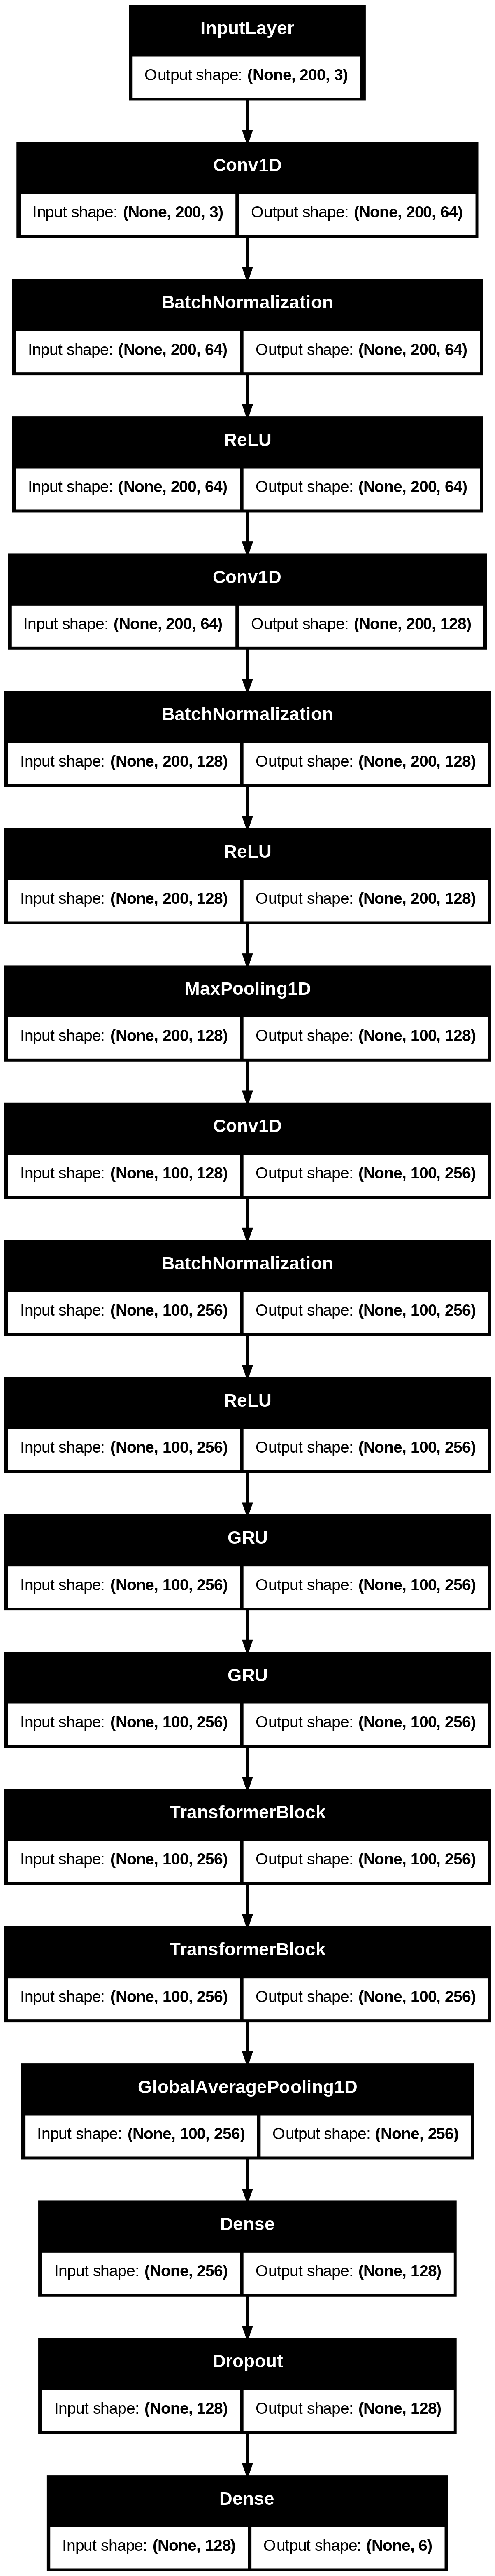

In [67]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [68]:
callbacks = [
            ModelCheckpoint(
                "WISDM_HAR_CNN_Transformer_best4.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [69]:
history = model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.5631 - sparse_categorical_accuracy: 0.7987
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.74413, saving model to WISDM_HAR_CNN_Transformer_best4.weights.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - loss: 0.5618 - sparse_categorical_accuracy: 0.7991 - val_loss: 2.2401 - val_sparse_categorical_accuracy: 0.7441
Epoch 2/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2720 - sparse_categorical_accuracy: 0.9183
Epoch 2: val_sparse_categorical_accuracy improved from 0.74413 to 0.82514, saving model to WISDM_HAR_CNN_Transformer_best4.weights.h5
327/327 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.2714 - sparse_categorical_accuracy: 0.9185 - val_loss: 1.5165 - val_sparse_categorical_accuracy: 0.8251
Epoch 3/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0926 - sparse_categorical_accuracy: 0.9694
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.82514
327/327 ━━━━━━━━━━━━━━━━━━━━ 4

In [70]:
# 모델 평가
model = build_model(input_shape, num_classes)
model.load_weights("WISDM_HAR_CNN_Transformer_best4.weights.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 110 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 95.07%
Training loss: 0.1404
Test accuracy: 91.46%
Test loss: 0.3839


In [71]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.6916    0.8362    0.7571       287
           1     1.0000    0.9217    0.9593      1009
           2     0.8912    0.9552    0.9221       223
           3     0.9380    0.8176    0.8736       148
           4     0.8145    0.7751    0.7943       289
           5     0.9406    0.9731    0.9566      1041

    accuracy                         0.9146      2997
   macro avg     0.8793    0.8798    0.8772      2997
weighted avg     0.9208    0.9146    0.9161      2997



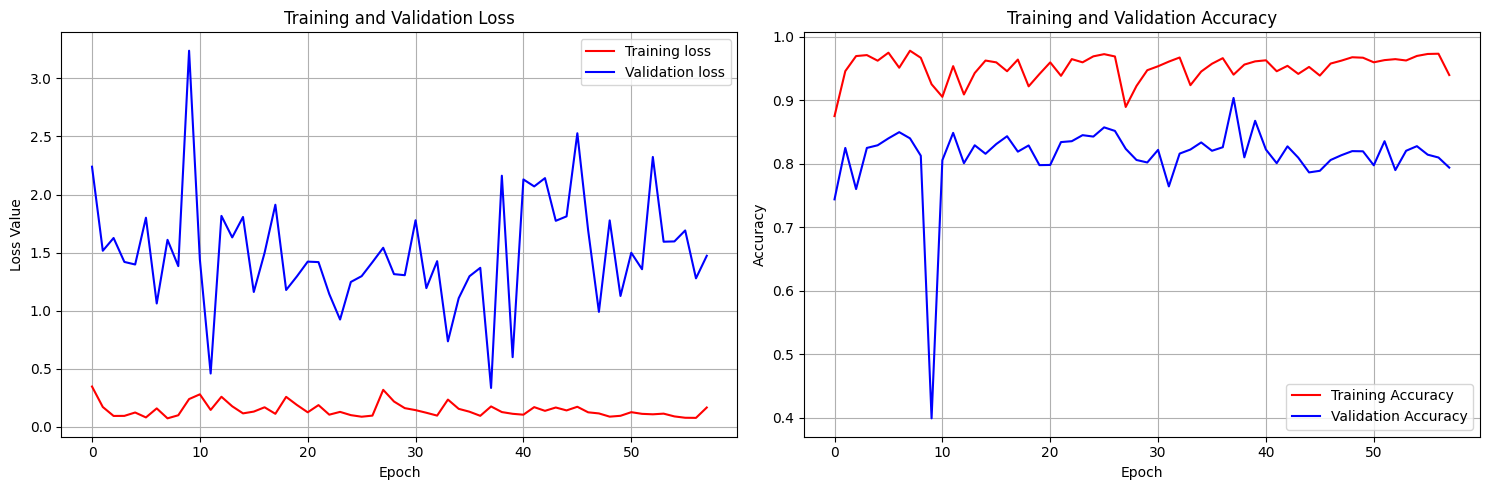

In [72]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

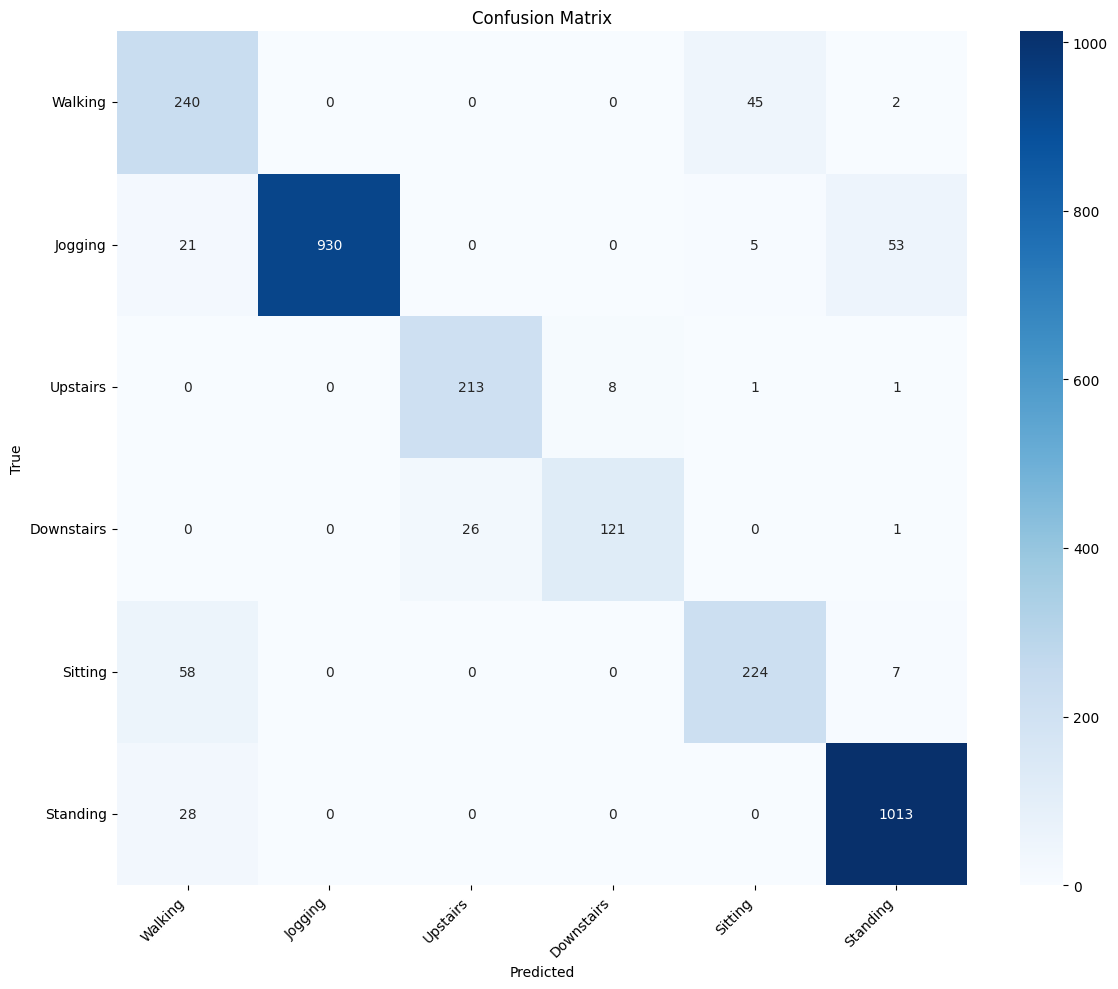

In [73]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()